In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.gridspec import GridSpec
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import XMLFile, KofamscanFile
from selenobot.utils import seed 
from selenobot.datasets import Dataset, get_dataloader
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from tqdm import tqdm
from scipy.stats import false_discovery_control, mannwhitneyu

%load_ext autoreload
%autoreload 2

In [2]:
label_map = dict()
label_map[0] = 'full-length'
label_map[1] = 'trunc. sel.'
label_map[2] = 'short full-len.'

color_map = {1:'tab:red', 2:'tab:blue', 0:'tab:green'}
color_map.update({'train':'tab:red', 'test':'tab:blue', 'val.':'tab:green'})
color_map.update({'evidence at protein level':'tab:green', 'inferred from homology':'tab:blue', 'predicted':'tab:red', 'evidence at transcript level':'tab:green', 'uncertain':'black'})

datasets = ['train', 'test', 'val.']

In [3]:
metadata_3c = dict()
metadata_3c['train'] = pd.read_csv('../data/3c_metadata_train.csv', index_col=0)
metadata_3c['test'] = pd.read_csv('../data/3c_metadata_test.csv', index_col=0)
metadata_3c['val.'] = pd.read_csv('../data/3c_metadata_val.csv', index_col=0)

metadata_2c = dict()
metadata_2c['train'] = pd.read_csv('../data/2c_metadata_train.csv', index_col=0)
metadata_2c['test'] = pd.read_csv('../data/2c_metadata_test.csv', index_col=0)
metadata_2c['val.'] = pd.read_csv('../data/2c_metadata_val.csv', index_col=0)

In [23]:
metadata_sec_df = pd.read_csv('../data/uniprot_metadata_sec.csv', index_col=0)
metadata_sec_bac_df = metadata_sec_df[metadata_sec_df.domain == 'Bacteria']
metadata_sec_bac_df = metadata_sec_df.merge(KofamscanFile('../data/uniprot_sec_bacteria.ko.tsv').to_df(), left_index=True, right_index=True, how='left')


In [25]:
metadata_sec_bac_df.ko.value_counts(dropna=False)


ko
NaN       17291
K22015      919
K14127      643
K22516      478
K21579      144
K24119      106
K21147       96
K21029       92
K14126       72
K22341       68
K21584       42
K18367       31
K24120       22
K22074       13
K17686        7
K16509        7
K10944        2
K18917        2
K24129        2
K16885        1
K13979        1
K16066        1
K17609        1
K16176        1
K18138        1
K24138        1
K13953        1
K11065        1
K24158        1
K24012        1
K15554        1
K27888        1
K11811        1
K16137        1
K14058        1
Name: count, dtype: int64

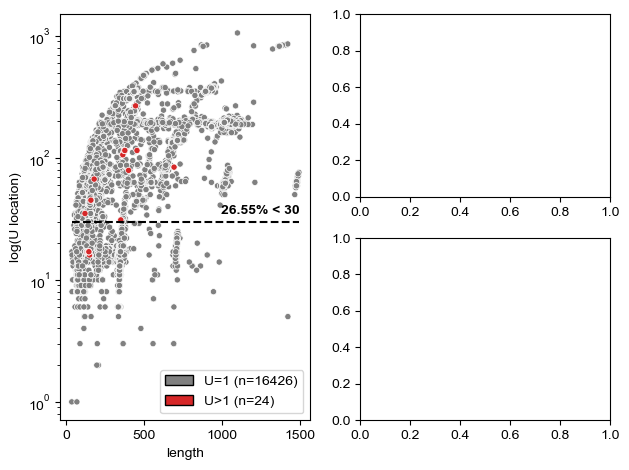

In [ ]:
# NOTE: Would it be more informative to plot this after de-replicating?
def figure_1(metadata_sec_df:pd.DataFrame, domain:str='Bacteria', min_length:int=30, path:str='../figures/datasets-figure_1.png'):
    '''Useful to characterize the known selenoproteins in UniProt.''' 
    fig = plt.figure(layout='tight')
    grid = GridSpec(nrows=2, ncols=2, figure=fig)

    metadata_sec_df = metadata_sec_df[metadata_sec_df.domain == domain].copy() # Only looking at the selenoproteins for a particular domain. 
    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = fig.add_subplot(grid[0, 1]) # Axis to show the top KO groups.
    ax_c = fig.add_subplot(grid[1, 1])

    metadata_sec_df['sec_count'] = [seq.count('U') for seq in metadata_sec_df.seq]
    metadata_sec_df['sec_idx'] = [seq.index('U') for seq in metadata_sec_df.seq]
    metadata_sec_df['length'] = metadata_sec_df.seq.apply(len)
    metadata_sec_df = metadata_sec_df.sort_values('sec_count') # Sort so that the red-labeled points are plotted in front.

    ax_a.scatter(metadata_sec_df.length, metadata_sec_df.sec_idx, s=20, edgecolor='white', lw=0.5, c=['gray' if (count == 1) else 'tab:red' for count in metadata_sec_df.sec_count])
    ax_a.hlines([min_length], ls='--', xmin=metadata_sec_df.length.min(), xmax=metadata_sec_df.length.max(), color='black', lw=1.5)
    ax_a.text(metadata_sec_df.length.max() - 500, min_length + 5, f'{100 * (metadata_sec_df.sec_idx < min_length).sum() / len(metadata_sec_df):.2f}% < {min_length}', fontweight='bold')
    ax_a.set_ylabel('log(U location)')
    ax_a.set_xlabel('length')
    ax_a.set_yscale('log')

    n_gt_1, n_eq_1 = (metadata_sec_df.sec_count > 1).sum(), (metadata_sec_df.sec_count == 1).sum()
    ax_a.legend(handles=[Patch(facecolor='gray', edgecolor='black', label=f'U=1 (n={n_eq_1})'), Patch(facecolor='tab:red', edgecolor='black', label=f'U>1 (n={n_gt_1})')])

        counts = np.array([(df.existence == cat).sum() for cat in cats])
        heights = counts / len(df)
        positions_ = positions + label * (bar_width + sep) 
        ax.bar(positions_, heights, label=label_map[label], color=color_map[label], width=bar_width, edgecolor='black', lw=0.7)

        for x, y, n in zip(positions_, heights, counts):
            ax.text(x, y + 0.005, str(n), fontsize='xx-small', ha='center')

    plt.show()


figure_1(metadata_sec_df)

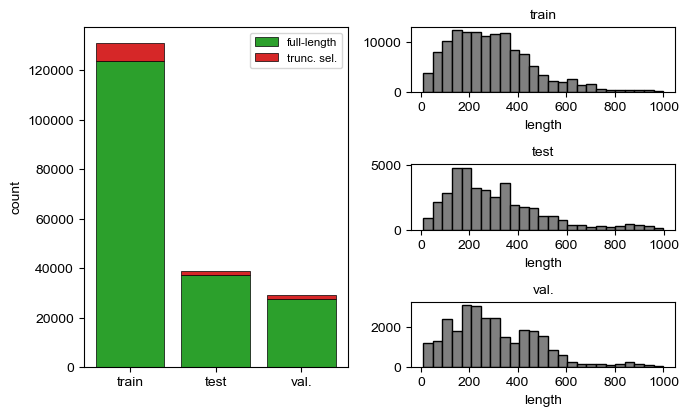

In [7]:
def figure_1(metadata:dict):
    '''Illustrating the composition of each split dataset.'''

    fig = plt.figure(layout='tight', figsize=(7, 8))
    grid = GridSpec(6, 2, figure=fig)

    ax_a = fig.add_subplot(grid[:3, 0])
    ax_b = [fig.add_subplot(grid[i, 1]) for i in range(0, 3)]

    labels = metadata['train'].label.unique()

    positions = np.arange(3)
    bottom = np.zeros(3)
    for label in labels:
        heights = np.array([(metadata[dataset]['label'] == label).sum() for dataset in datasets])
        ax_a.bar(positions, heights, bottom=bottom, color=color_map[label], edgecolor='black', lw=0.5)
        bottom += heights 

    ax_a.set_ylabel('count')
    ax_a.set_xticks(positions, datasets)
    ax_a.legend([label_map[label] for label in labels], loc='upper right', fontsize='small')

    for ax, dataset in zip(ax_b, datasets):
        ax.hist(metadata[dataset].seq.apply(len), bins=25, lw=0.5, edgecolor='black', color='gray')
        ax.set_title(dataset, fontsize='medium')
        # ax.set_ylabel('count')
        ax.set_xlabel('length')
    
    plt.show()


figure_1(metadata_2c)




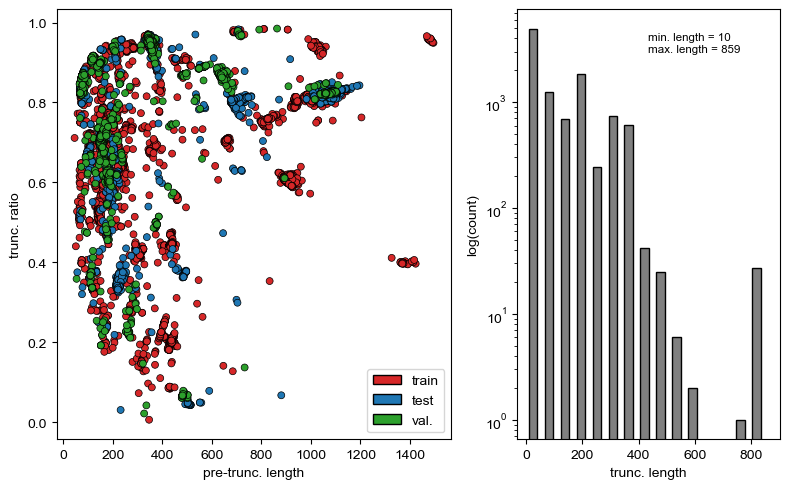

In [8]:
# What are the truncation ratio distributions for the selenoprotein? How short is the shortest one?

metadata_2c_1_df = pd.concat([df[df.label == 1].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 
metadata_2c_0_df = pd.concat([df[df.label == 0].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 

fig, axes = plt.subplots(ncols=2, figsize=(8, 5), width_ratios=[0.6, 0.4], layout='tight')

ax = axes[0]

colors = metadata_2c_1_df.dataset.replace(color_map).values
ax.scatter(metadata_2c_1_df.original_length, metadata_2c_1_df.truncation_ratio, s=25, c=colors, edgecolors='black', lw=0.5)
ax.set_xlabel('pre-trunc. length')
ax.set_ylabel('trunc. ratio')
ax.legend(handles=[Patch(facecolor=color_map[dataset], label=dataset, edgecolor='black') for dataset in datasets], loc='lower right')

ax = axes[1]
ax.hist(metadata_2c_1_df.seq.apply(len), bins=15, width=30, edgecolor='black', color='gray')
ax.set_ylabel('log(count)')
ax.set_xlabel('trunc. length')
ax.set_yscale('log')
ax.text(0.5, 0.9, f'min. length = {metadata_2c_1_df.seq.apply(len).min()}\nmax. length = {metadata_2c_1_df.seq.apply(len).max()}', transform=ax.transAxes, fontsize='small')

plt.show()

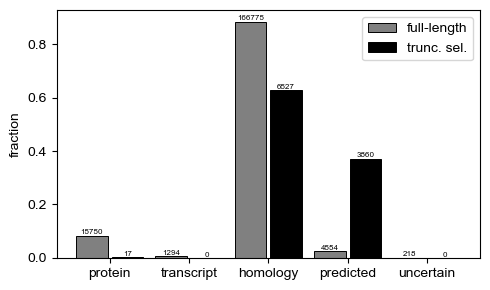

In [9]:
# I think it also might be valuable to assess sequence quality... 

def figure_3(metadata:dict):

    fig, ax = plt.subplots(figsize=(5, 3), layout='tight')

    metadata_df = pd.concat(list(metadata.values())) # Grab all metadata. 
    labels = metadata_df.label.unique()

    cats = ['evidence at protein level', 'evidence at transcript level', 'inferred from homology', 'predicted', 'uncertain']
    cats_map = {'evidence at protein level':'protein', 'evidence at transcript level':'transcript', 'inferred from homology':'homology', 'predicted':'predicted', 'uncertain':'uncertain'} 

    bar_width = 0.4
    sep = 0.05
    positions = np.arange(len(cats))
    color_map = {0:'gray', 1:'black'}
    
    for label, df in metadata_df.groupby('label'):
        counts = np.array([(df.existence == cat).sum() for cat in cats])
        heights = counts / len(df)
        positions_ = positions + label * (bar_width + sep) 
        ax.bar(positions_, heights, label=label_map[label], color=color_map[label], width=bar_width, edgecolor='black', lw=0.7)

        for x, y, n in zip(positions_, heights, counts):
            ax.text(x, y + 0.005, str(n), fontsize='xx-small', ha='center')

    ax.set_xticks(positions + (bar_width + sep) / 2, labels=[cats_map[cat] for cat in cats])
    ax.set_ylabel('fraction')
    ax.legend(labels=[label_map[label] for label in labels])

    plt.show()


figure_3(metadata_2c)